# Reproduction of A CFCC-LSTM Model for Sea Surface Temperature Prediction
**Reproducibility project - CS4240 Deep Learning**

Group 86
Matthijs Arnoldus (@: m.arnoldus-1@student.tudelft.nl, 4928091)
Marius Birkhoff (@: M.J.H.Birkhoff@student.tudelft.nl, 4724259)
Luuk Haarman (@: L.A.Haarman@student.tudelft.nl, 4931173)

Load and quickly explore the data.

<ipython-input-1-dd09dd1da6e2>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, sst[0], vmin=0.01, vmax=30)


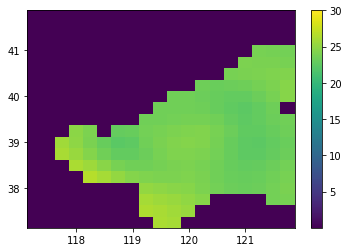

In [1]:
# Data preparation
import torch
import torch.nn as nn
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import sys

# Get training data
ds = nc.Dataset("./data/sst.bohai.day.mean.1981-2021.nc")

latitudes = ds.variables['lat']
longitudes = ds.variables['lon']
sst = np.clip(np.array(ds.variables['sst']), a_min=0.01, a_max=None)
X, Y = np.meshgrid(longitudes[:], latitudes[:])

plt.figure()
plt.pcolor(X, Y, sst[0], vmin=0.01, vmax=30)
plt.colorbar()
plt.show()

In [2]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


The following PyTorch module implements the FCLSTM network to predict sea surface temperatures.

In [3]:
class FCLSTM(nn.Module):
  def __init__(self, input_size=25, hidden_size=25, history_length=4, prediction_length=1, device='cpu'): 
    super(FCLSTM, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    
    self.history_length = history_length
    self.prediction_length = prediction_length

    self.device = device

    self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
    self.fc_layer = nn.Linear(history_length * hidden_size, prediction_length * hidden_size)
    self.relu = nn.ReLU()

  # takes in a grid of N x history_length x 25 and returns a grid of N x prediction_length x 5 x 5 
  def forward(self, input, reshape=True):
      num_samples = input.shape[0]
      h_t = torch.zeros(1, num_samples, self.hidden_size).to(self.device)
      c_t = torch.zeros(1, num_samples, self.hidden_size).to(self.device)

      output, (h_t, c_t) = self.lstm_layer(input, (h_t, c_t)) # output: N x history_length x 25
      output = torch.flatten(output, start_dim=1) # = N x history_length * 25
      output = self.fc_layer(output) # = N x prediction_length * 25
      if reshape:
        output = torch.reshape(output, (num_samples, self.prediction_length, int(np.sqrt(self.hidden_size)), int(np.sqrt(self.hidden_size)))) # N x prediction_length x 5 x 5

      output = self.relu(output)
      return output

The previously built FCLSTM is combined with a convolutional layer. This results in a CFCCLSTM network.

In [4]:
class CFCCLSTM(FCLSTM):
  def __init__(self, input_size=25, hidden_size=25, history_length=4, prediction_length=1, device="cpu", mode="weighted"): 
    super(CFCCLSTM, self).__init__(input_size, hidden_size, history_length, prediction_length, device)

    self.conv_layer = nn.Conv1d(prediction_length,prediction_length, kernel_size=hidden_size, stride=1, padding=0)
    if mode == "average":
      with torch.no_grad():
        self.conv_layer.weight.data = torch.mul(torch.ones(prediction_length, prediction_length, hidden_size), 1.0 / hidden_size)
        self.conv_layer.weight.requires_grad = False

  # takes in a grid of N x history_length x 25 and returns a grid of N x prediction_length x 5 x 5 
  def forward(self, input):
      output = super().forward(input, False) # N x prediction_length x 5 x 5

      # put data in 1 channel
      unflatten = nn.Unflatten(1, (self.prediction_length, self.hidden_size))
      output = unflatten(output) # N x 1 x 25
      output = self.conv_layer(output) # N x 1 x 1
      output = torch.flatten(output, start_dim=1)

      return output

The following class is a helper for training and testing of the FCLSTM network.

In [5]:
class FCLSTM_SSTPredictor:
    def __init__(self, sst, model, history_length, prediction_length, batch_size, device="cpu", epochs = 50):
        self.sst = sst
        self.sequence_length = self.sst.shape[0]
        self.history_length = history_length
        self.prediction_length = prediction_length
        self.batch_size = batch_size
        self.device = device
        self.epochs = epochs

        self.model = model.to(self.device)

    def transform_data(self, data):
        x = []
        y = []

        data_length = data.shape[0]

        for t in range(1 + data_length - self.history_length - self.prediction_length):
            for lat in range(16):
                for lon in range(16):
                    x.append(
                        self.sst[t:t + self.history_length, lat:lat+5, lon:lon+5]
                    )
                    y.append(
                        self.sst[t + self.history_length:t + self.history_length + self.prediction_length, lat:lat+5, lon:lon+5]
                    )
        
        x_tensor = torch.Tensor(np.asarray(x)).flatten(start_dim=2)
        y_tensor = torch.Tensor(np.asarray(y))

        return x_tensor, y_tensor

    def train_test(self, split=4/5):
        return self.sst[:int(len(self.sst) * split), :, :], self.sst[int(len(self.sst) * split):, :, :]

    def make_batches(self, x, y):
        return list(zip(x.split(self.batch_size), y.split(self.batch_size)))

    def criterion(self, output, target):
        return torch.sqrt(nn.MSELoss()(output, target))
    
    def accuracy(self, output, target):
        return 1 - torch.mean(torch.divide(torch.mean(torch.subtract(output, target)), target))

    def train(self, batches):
        print("Running training...")
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)

        losses = []
        accuracies = []

        
        for i in range(self.epochs):
  
            if len(losses) > 0:
                sys.stdout.write('\r'+ "Current iteration: " + str(i) + ", previous loss: " + str(losses[len(losses) - 1]) + ", previous accuracy: " + str(accuracies[len(accuracies) - 1]) + "\n")
                sys.stdout.flush()

            sumLosses = []
            sumAccuracies = []

            for batch in batches:
                # Randomly initialize hidden
                train_input = batch[0].to(self.device)
                train_target = batch[1].to(self.device)

                optimizer.zero_grad()
                output = self.model(train_input) # batch_size x prediction_length x 5 x 5

                loss = self.criterion(output, train_target)
                accuracy = self.accuracy(output, train_target)

                sumLosses.append(loss.item())
                sumAccuracies.append(accuracy.item())

                loss.backward()
                optimizer.step() 

            losses.append(np.mean(sumLosses))
            accuracies.append(np.nanmean(sumAccuracies))
        
        return losses, accuracies

    def test(self, batches):
        print("Running test...")

        sumLosses = []
        sumAccuracies = []

        with torch.no_grad():
            for batch in batches:
                test_input = batch[0].to(self.device)
                test_target = batch[1].to(self.device)
                output = self.model(test_input) # batch_size x prediction_length x 5 x 5

                loss = self.criterion(output, test_target)
                accuracy = self.accuracy(output, test_target)

                sumLosses.append(loss.item())
                sumAccuracies.append(accuracy.item())

        return sumLosses, sumAccuracies
    
    def train_plot(self, losses, accuracies):        
        plt.title("Loss (RMSE)")
        plt.plot(list(range(0, self.epochs)), losses)
        plt.figure()
        plt.title("Accuracy")
        plt.plot(list(range(0, self.epochs)), accuracies)

    def test_plot(self, losses, accuracies):
        print("RMSE for validation:", np.mean(losses))
        print("Accuracy for validation:", np.mean(accuracies))

Train and test the FCLSTM network.

Running training...
Current iteration: 1, previous loss: 5.883089294820235, previous accuracy: 136.57844055210825
Current iteration: 2, previous loss: 3.7109025377281974, previous accuracy: 37.037203586696364
Current iteration: 3, previous loss: 2.973310912790464, previous accuracy: 18.118313657411974
Current iteration: 4, previous loss: 2.535714268163403, previous accuracy: 12.522109595533948
Current iteration: 5, previous loss: 2.2313386868414877, previous accuracy: 9.698387370838734
Current iteration: 6, previous loss: 2.0034314864754514, previous accuracy: 7.977397196950835
Current iteration: 7, previous loss: 1.825547694649044, previous accuracy: 6.724166525296427
Current iteration: 8, previous loss: 1.685727372406416, previous accuracy: 5.901061242078327
Current iteration: 9, previous loss: 1.5731200753772494, previous accuracy: 5.336289222719551
Current iteration: 10, previous loss: 1.4792250281823223, previous accuracy: 4.872773663919149
Current iteration: 11, previous loss: 1.

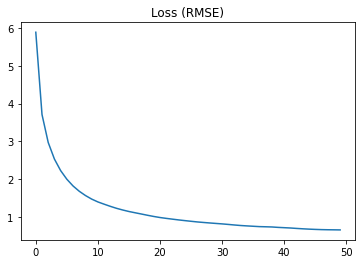

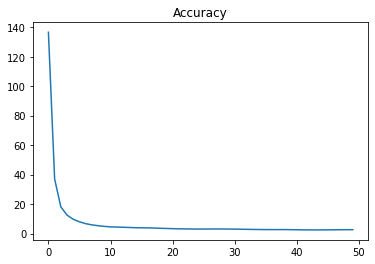

In [6]:
model = FCLSTM(25, 25, 4, 1, device=device)

sst_predictor = FCLSTM_SSTPredictor(sst, model, 4, 1, 1024, epochs=50, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

x_test, y_test = sst_predictor.transform_data(test_data)
test_batches = sst_predictor.make_batches(x_test, y_test)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

test_loss, test_accuracy = sst_predictor.test(test_batches)
sst_predictor.test_plot(test_loss, test_accuracy)

Extended version of the helper class to support CFCCLSTM networks.

In [7]:
class CFCCLSTM_SSTPredictor(FCLSTM_SSTPredictor):   

    def transform_data(self, data):
        x = []
        y = []

        data_length = data.shape[0]

        for t in range(1 + data_length - self.history_length - self.prediction_length):
            for lat in range(16):
                for lon in range(16):
                    x.append(
                        self.sst[t:t + self.history_length, lat:lat+5, lon:lon+5]
                    )
                    y.append(
                        self.sst[t + self.history_length:t + self.history_length + self.prediction_length, lat + 2, lon + 2]
                    )
        
        x_tensor = torch.Tensor(np.asarray(x)).flatten(start_dim=2)
        y_tensor = torch.Tensor(np.asarray(y))

        return x_tensor, y_tensor

Train and test the weighted CFCCLSTM.

Running training...
Current iteration: 1, previous loss: 3.7348501913537806, previous accuracy: 76.15047271380762
Current iteration: 2, previous loss: 1.4280774088251453, previous accuracy: -6.691936145023837
Current iteration: 3, previous loss: 1.1314298961910965, previous accuracy: -7.586197254088001
Current iteration: 4, previous loss: 1.0007070190546994, previous accuracy: -6.552462349800698
Current iteration: 5, previous loss: 0.9247470932601062, previous accuracy: -5.622310180082988
Current iteration: 6, previous loss: 0.8708790424915293, previous accuracy: -4.81046116070851
Current iteration: 7, previous loss: 0.8287094214075047, previous accuracy: -4.110457640679936
Current iteration: 8, previous loss: 0.7945194056653402, previous accuracy: -3.5037991903464323
Current iteration: 9, previous loss: 0.7654303162632471, previous accuracy: -2.9661660999646418
Running test...
RMSE for validation: 0.6841467361613784
Accuracy for validation: 4.633253382113964


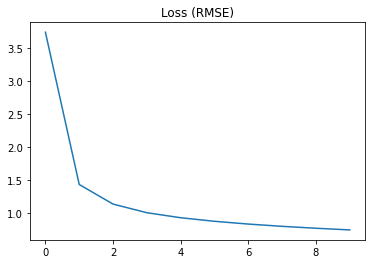

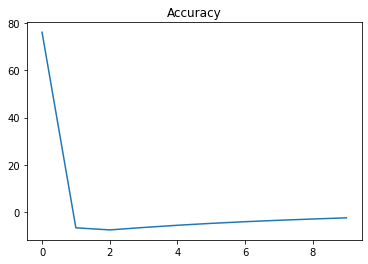

In [9]:
model = CFCCLSTM(25, 25, 4, 1, device=device)

sst_predictor = CFCCLSTM_SSTPredictor(sst, model, 4, 1, 1024, epochs=10, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

x_test, y_test = sst_predictor.transform_data(test_data)
test_batches = sst_predictor.make_batches(x_test, y_test)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

test_loss, test_accuracy = sst_predictor.test(test_batches)
sst_predictor.test_plot(test_loss, test_accuracy)

Train and test the average CFCCLSTM.

Running training...
Current iteration: 1, previous loss: 4.5884632991989776, previous accuracy: 128.65999429932438
Current iteration: 2, previous loss: 1.7643516532828916, previous accuracy: 13.715426399626056
Current iteration: 3, previous loss: 1.1995807110969905, previous accuracy: -2.7432207845338574
Current iteration: 4, previous loss: 1.0002429565694246, previous accuracy: -4.5560553488040245
Current iteration: 5, previous loss: 0.9021000872338943, previous accuracy: -4.464245107593944
Current iteration: 6, previous loss: 0.8416546013127842, previous accuracy: -3.9325161110723577
Current iteration: 7, previous loss: 0.7992061079205984, previous accuracy: -3.311605023937167
Current iteration: 8, previous loss: 0.7666441757214247, previous accuracy: -2.706648332341868
Current iteration: 9, previous loss: 0.7396623042247081, previous accuracy: -2.1807299805634375
Running test...
RMSE for validation: 0.61174430802424
Accuracy for validation: 5.22005034254297


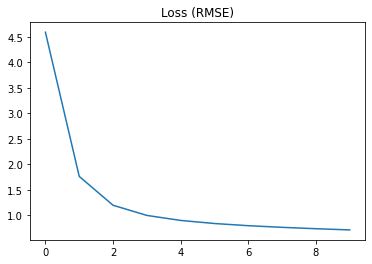

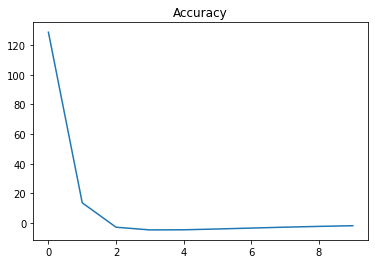

In [10]:
model = CFCCLSTM(25, 25, 4, 1, mode="average", device=device)

sst_predictor = CFCCLSTM_SSTPredictor(sst, model, 4, 1, 1024, epochs=10, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

x_test, y_test = sst_predictor.transform_data(test_data)
test_batches = sst_predictor.make_batches(x_test, y_test)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

test_loss, test_accuracy = sst_predictor.test(test_batches)
sst_predictor.test_plot(test_loss, test_accuracy)

Train and the network for prediction of seven days, to plot below.

Running training...
Current iteration: 1, previous loss: 3.085921379954231, previous accuracy: -9.46885014666992
Current iteration: 2, previous loss: 2.1950870952942743, previous accuracy: -19.828573485641254
Current iteration: 3, previous loss: 1.8369329748307766, previous accuracy: -12.151325517365722
Current iteration: 4, previous loss: 1.53541791530288, previous accuracy: -4.906354757616309
Current iteration: 5, previous loss: 1.3168174176749323, previous accuracy: -0.9037753806430466
Current iteration: 6, previous loss: 1.1638325464107147, previous accuracy: 0.910954348996383
Current iteration: 7, previous loss: 1.0624424401594668, previous accuracy: 1.8658059172281602
Current iteration: 8, previous loss: 0.9885323073486892, previous accuracy: 2.2195431369908003
Current iteration: 9, previous loss: 0.9359576099989365, previous accuracy: 2.344373365567655


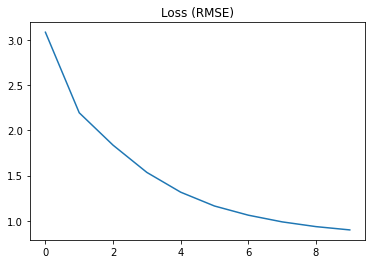

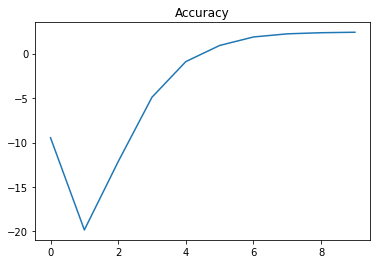

In [12]:
model = CFCCLSTM(25, 25, 20, 7, mode="average", device=device)
sst_predictor = CFCCLSTM_SSTPredictor(sst, model, 20, 7, 1024, epochs=10, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

<ipython-input-17-61f83f369464>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


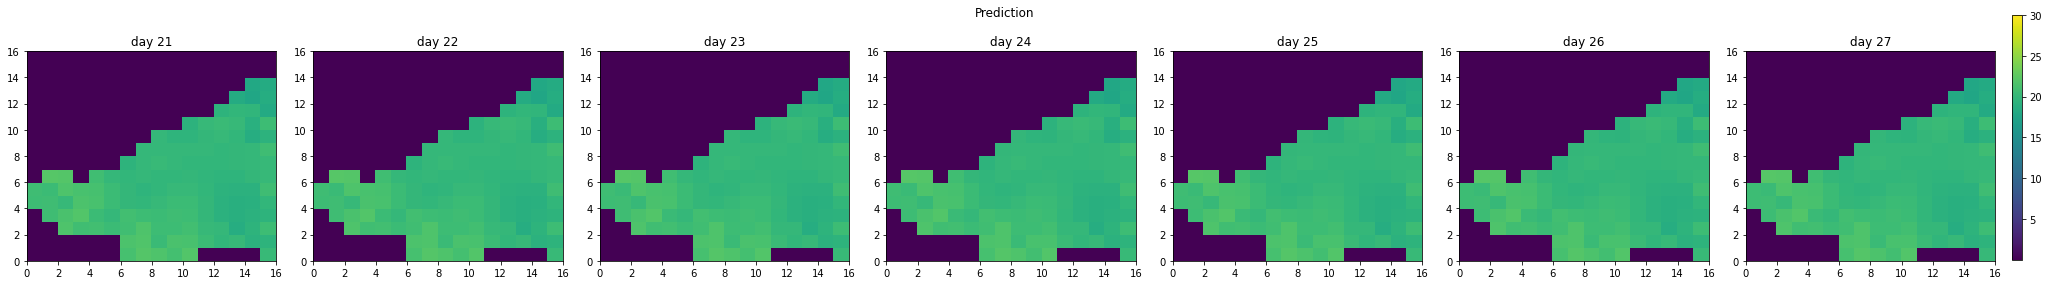

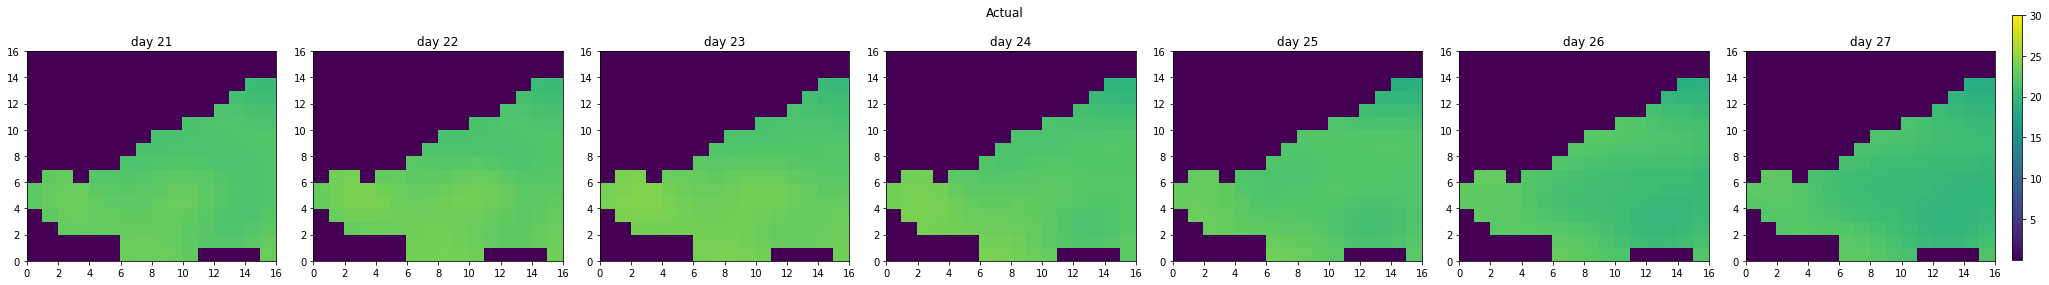

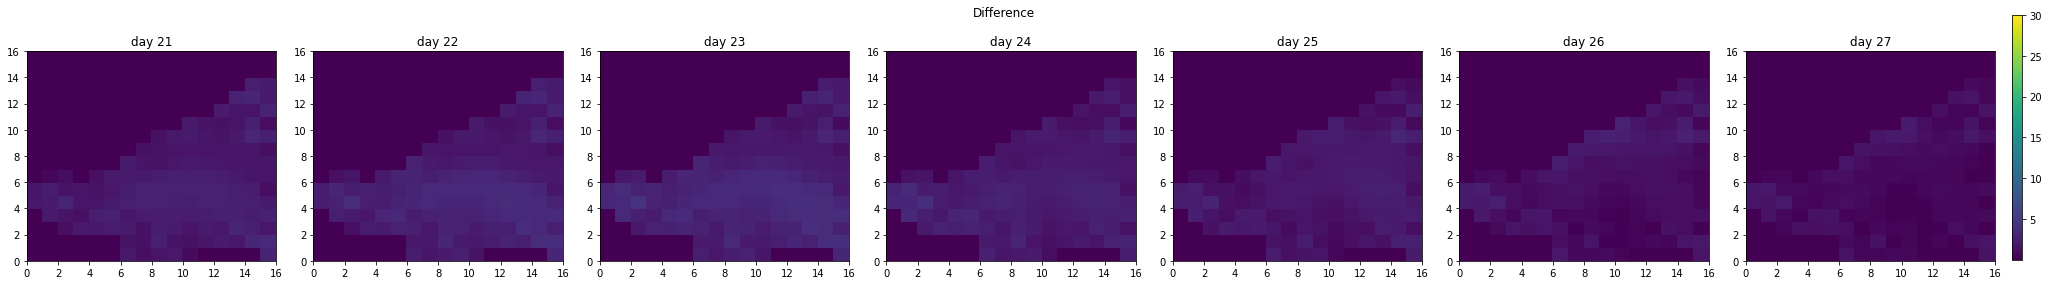

In [17]:
x,y = sst_predictor.transform_data(test_data[1200:1227])

output = model(x.to(device)) # N x 7 x 25
output = output.transpose(0,1)
output = torch.reshape(output, (7, 16,16))

ground_truth = y.reshape((16, 16, 7)).numpy().transpose(2,0,1)
predicted_days = np.asarray(output.tolist())

def plot_days(days, title):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(28, 4))
  fig.suptitle(title)
  for i, day in enumerate(days):
    im = axes[i].pcolor(day, vmin=0.01, vmax=30)
    axes[i].set_title("day {}".format(i + 21))

  fig.subplots_adjust(right=2)

  cb_ax = fig.add_axes([1.00, 0.1, 0.005, 0.85])
  cbar = fig.colorbar(im, cax=cb_ax)
  fig.tight_layout()
  plt.show()

plot_days(predicted_days, "Prediction")
plot_days(ground_truth, "Actual")

differences = np.abs(np.subtract(ground_truth, predicted_days))
plot_days(differences, "Difference")